In [23]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

In [ ]:
# 경로 설정
data_dir = '../data'
train_dir = os.path.join(data_dir, 'train')
csv_file = os.path.join(data_dir, 'train_updated.csv')

In [ ]:
# CSV 파일 로드
df = pd.read_csv(csv_file)


In [ ]:
# 클래스별 이미지 개수 계산
class_counts = df['target'].value_counts().sort_index()

# 막대 그래프 시각화
plt.figure(figsize=(8, 3))
class_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.xticks(ticks=class_counts.index, labels=[f'Class {i}' for i in class_counts.index], rotation=45)
plt.grid(axis='y')

plt.show()

In [ ]:
# 열 이름 수정 (필요한 열 이름으로 변경)
filename_col = 'ID'     # 실제 열 이름으로 변경
label_col = 'target'    # 실제 열 이름으로 변경

In [ ]:
# # 클래스 선택 (예: 클래스 0)
# selected_class = 7
# # 선택한 클래스의 데이터 필터링
# class_df = df[df['target'] == selected_class]


In [ ]:
# # 시각화할 이미지 개수 설정
# num_images = 100

# # 행과 열 개수 계산
# num_cols = 5
# num_rows = math.ceil(num_images / num_cols)

In [ ]:
# 샘플링된 데이터
# sampled_df = class_df.sample(n=num_images)

In [ ]:
# # 이미지 시각화
# plt.figure(figsize=(num_cols * 4, num_rows * 6))
# for idx, row in enumerate(class_df.itertuples(), 1):
#     img_path = os.path.join(train_dir, getattr(row, filename_col))
#     img = mpimg.imread(img_path)
#     plt.subplot(num_rows, num_cols, idx)
#     plt.imshow(img)
#     plt.title(getattr(row, filename_col))  # 파일 이름을 제목으로 설정
#     plt.axis('off')

# plt.tight_layout()
# plt.show()

In [1]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


In [2]:

# 데이터 증강 정의
augmentation = A.Compose([
    #A.RandomCrop(width=256, height=256, p=1.0),
    A.Rotate(limit=40, p=1.0),
    A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    ToTensorV2()
])



In [3]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, class_id, image_folder, transform=None):
        self.dataframe = dataframe
        self.class_id = class_id
        self.image_folder = image_folder
        self.transform = transform
        self.image_paths = self.dataframe[self.dataframe['target'] == self.class_id]['ID'].values

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            augmented = self.transform(image=np.array(image))['image']
            image = augmented

        return image, img_name

def save_augmented_images(image, original_name, output_folder, count):
    saved_paths = []
    for i in range(count):
        # 확장자 문제를 피하기 위해 확장자를 명확히 지정
        base_name, ext = os.path.splitext(original_name)
        augmented_name = f"augmented_{i}_{base_name}{ext}"
        output_path = os.path.join(output_folder, augmented_name)
        img_pil = transforms.ToPILImage()(image)
        img_pil.save(output_path)
        saved_paths.append(augmented_name)
    return saved_paths



In [4]:
# 설정
class_id_to_augment = 17  # 증강하고자 하는 클래스 ID  17/ 17, 13(0.38)
output_folder = '../data/train_test/'
output_count_per_image = 1


# # 폴더가 없으면 생성
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 데이터 로드
df = pd.read_csv('../data/train_updated.csv')

# # 전체 데이터에서 일정 비율만큼 샘플 선택/ class 13일때 사용
# augmentation_fraction = 1.1  # 전체 데이터의 50%를 증강
# label_1 = df[df['target']==1]
# sample_df_1 = label_1.sample(frac=augmentation_fraction, replace=True, random_state=42)  # frac=0.5는 50% 선택

# # CustomDataset 인스턴스 생성/ class 13일때 사용
# dataset = CustomDataset(dataframe=sample_df_1, class_id=class_id_to_augment, image_folder='../data/train', transform=augmentation)

# CustomDataset 인스턴스 생성/ class 1, 14일때 사용
dataset = CustomDataset(dataframe=df, class_id=class_id_to_augment, image_folder='../data/train', transform=augmentation)

# DataLoader 설정
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)




In [5]:
# 증강된 이미지와 원본 이미지 정보를 저장할 리스트
augmented_data = []

# 데이터 증강 및 저장
for i, (image, original_name) in enumerate(data_loader):
    image = image[0]  # batch_size가 1이므로 첫 번째 아이템만 사용
    original_name = original_name[0]  # 튜플의 첫 번째 요소가 원본 이미지 이름
    augmented_names = save_augmented_images(image, original_name, output_folder, output_count_per_image)
    for augmented_name in augmented_names:
        augmented_data.append({
            'ID': augmented_name,
            'target': class_id_to_augment
        })

In [6]:
# 증강된 데이터 정보를 원본 데이터프레임에 추가
augmented_df = pd.DataFrame(augmented_data)
augmented_df.to_csv('../data/train_updated_17_1.csv', index=False)

print("증강 완료 및 CSV 파일 업데이트 완료.")



증강 완료 및 CSV 파일 업데이트 완료.


In [7]:
# # 폴더가 없으면 생성
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

class_id_to_augment = 17

# 데이터 로드
df = pd.read_csv('../data/train_updated_17_1.csv')

# 전체 데이터에서 일정 비율만큼 샘플 선택/ class 13일때 사용
augmentation_fraction = 0.6  # 전체 데이터의 50%를 증강
label_17 = df[df['target']==17]
sample_df = label_17.sample(frac=augmentation_fraction, random_state=42)  # frac=0.5는 50% 선택

# CustomDataset 인스턴스 생성/ class 13일때 사용
dataset = CustomDataset(dataframe=sample_df, class_id=class_id_to_augment, image_folder='../data/train_test/', transform=augmentation)

# # CustomDataset 인스턴스 생성/ class 1, 14일때 사용
# dataset = CustomDataset(dataframe=df, class_id=class_id_to_augment, image_folder='../data/train', transform=augmentation)

# DataLoader 설정
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)




In [8]:
# 증강된 이미지와 원본 이미지 정보를 저장할 리스트
augmented_data = []

# 데이터 증강 및 저장
for i, (image, original_name) in enumerate(data_loader):
    image = image[0]  # batch_size가 1이므로 첫 번째 아이템만 사용
    original_name = original_name[0]  # 튜플의 첫 번째 요소가 원본 이미지 이름
    augmented_names = save_augmented_images(image, original_name, output_folder, output_count_per_image)
    for augmented_name in augmented_names:
        augmented_data.append({
            'ID': augmented_name,
            'target': class_id_to_augment
        })

In [9]:
# 증강된 데이터 정보를 원본 데이터프레임에 추가
augmented_df = pd.DataFrame(augmented_data)
augmented_df.to_csv('../data/train_updated_17_2.csv', index=False)

print("증강 완료 및 CSV 파일 업데이트 완료.")



증강 완료 및 CSV 파일 업데이트 완료.


In [10]:
# # 폴더가 없으면 생성
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

class_id_to_augment = 7

# 데이터 로드
df = pd.read_csv('../data/train_updated.csv')

# 전체 데이터에서 일정 비율만큼 샘플 선택/ class 13일때 사용
augmentation_fraction = 0.6  # 전체 데이터의 50%를 증강
label_7 = df[df['target']==7]
sample_df = label_7.sample(frac=augmentation_fraction, random_state=42)  # frac=0.5는 50% 선택

# CustomDataset 인스턴스 생성/ class 13일때 사용
dataset = CustomDataset(dataframe=sample_df, class_id=class_id_to_augment, image_folder='../data/train/', transform=augmentation)

# # CustomDataset 인스턴스 생성/ class 1, 14일때 사용
# dataset = CustomDataset(dataframe=df, class_id=class_id_to_augment, image_folder='../data/train', transform=augmentation)

# DataLoader 설정
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)




In [11]:
# 증강된 이미지와 원본 이미지 정보를 저장할 리스트
augmented_data = []

# 데이터 증강 및 저장
for i, (image, original_name) in enumerate(data_loader):
    image = image[0]  # batch_size가 1이므로 첫 번째 아이템만 사용
    original_name = original_name[0]  # 튜플의 첫 번째 요소가 원본 이미지 이름
    augmented_names = save_augmented_images(image, original_name, output_folder, output_count_per_image)
    for augmented_name in augmented_names:
        augmented_data.append({
            'ID': augmented_name,
            'target': class_id_to_augment
        })

In [12]:
# 증강된 데이터 정보를 원본 데이터프레임에 추가
augmented_df = pd.DataFrame(augmented_data)
augmented_df.to_csv('../data/train_updated_7.csv', index=False)

print("증강 완료 및 CSV 파일 업데이트 완료.")



증강 완료 및 CSV 파일 업데이트 완료.


In [13]:
data_path = '../data/'
df = pd.read_csv(f'{data_path}train_updated.csv')
df1 = pd.read_csv(f'{data_path}train_updated_7.csv')
df2 = pd.read_csv(f'{data_path}train_updated_17_1.csv')
df3 = pd.read_csv(f'{data_path}train_updated_17_2.csv')


In [14]:
new_df = pd.concat([df,df1,df2,df3],axis=0)

In [15]:
new_df

,ID,target
0,002f99746285dfdd.jpg,16
1,008ccd231e1fea5d.jpg,10
2,008f5911bfda7695.jpg,10
3,009235e4c9c07af5.jpg,4
4,00b2f44967580c74.jpg,16
...,...,...
18,augmented_0_augmented_0_988fa031ea841a40.jpg,17
19,augmented_0_augmented_0_1af85d095317707e.jpg,17
20,augmented_0_augmented_0_4ca2ec8f7f492b0d.jpg,17
21,augmented_0_augmented_0_067f25e0435ab78b.jpg,17


In [16]:
import pandas as pd

In [18]:
new_df.to_csv("../data/new_train_class_17.csv", index=False)

In [19]:
new_df = pd.read_csv("../data/new_train_class_17.csv")

In [20]:
new_df

,ID,target
0,002f99746285dfdd.jpg,16
1,008ccd231e1fea5d.jpg,10
2,008f5911bfda7695.jpg,10
3,009235e4c9c07af5.jpg,4
4,00b2f44967580c74.jpg,16
...,...,...
1786,augmented_0_augmented_0_988fa031ea841a40.jpg,17
1787,augmented_0_augmented_0_1af85d095317707e.jpg,17
1788,augmented_0_augmented_0_4ca2ec8f7f492b0d.jpg,17
1789,augmented_0_augmented_0_067f25e0435ab78b.jpg,17


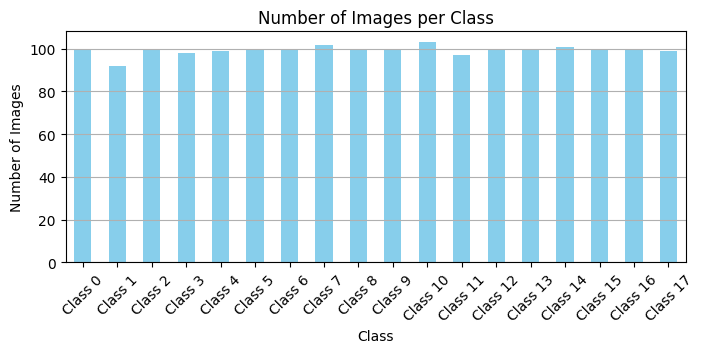

In [24]:
# 클래스별 이미지 개수 계산
class_counts = new_df['target'].value_counts().sort_index()

# 막대 그래프 시각화
plt.figure(figsize=(8, 3))
class_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.xticks(ticks=class_counts.index, labels=[f'Class {i}' for i in class_counts.index], rotation=45)
plt.grid(axis='y')

plt.show()

In [22]:
# new_df.to_csv('../data/new_train.csv', index=False)